<h2>Mounting drive<h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


<h2> Importing dependencies <h2>

In [2]:
import os
os.chdir("/content/drive/My Drive")
import pandas as pd
import tensorflow as tf
import numpy as np

<h2>Reading the dataset<h2>

In [3]:
df = pd.read_csv(os.path.join('ml projects','toxicity','archive','train.csv' ))

In [ ]:
df.shape

(159571, 8)

In [ ]:
#checking for missing values & duplicates
df.isnull().values.any()
df.duplicated().values.any()

False

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [ ]:
df.iloc[1]['comment_text']

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

<h2>Data Pre-processing<h2>

In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
MAX_FEATURES = 200000

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=1800, output_mode='int')
vectorizer.adapt(x.values)

In [8]:
vectorized_text= vectorizer(x.values)

In [ ]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [ ]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [ ]:
vectorizer("Hi there! This is a test statement.")

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([171,  41,  14, ...,   0,   0,   0])>

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
train_generator = train.as_numpy_iterator()

<h2>Creating the deep learning Model<h2>

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(6, activation = 'sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer = 'Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs =5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 740s 105ms/step - loss: 0.0656 - val_loss: 0.0457
Epoch 2/5
6981/6981 [==============================] - 599s 86ms/step - loss: 0.0459 - val_loss: 0.0400
Epoch 3/5
6981/6981 [==============================] - 587s 84ms/step - loss: 0.0407 - val_loss: 0.0355
Epoch 4/5
6981/6981 [==============================] - 586s 84ms/step - loss: 0.0365 - val_loss: 0.0313
Epoch 5/5
6981/6981 [==============================] - 587s 84ms/step - loss: 0.0326 - val_loss: 0.0282


In [ ]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

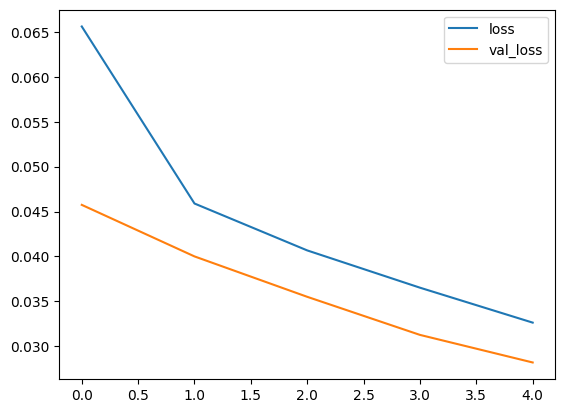

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

<h2>Making Predictions<h2>

In [ ]:
input_text = vectorizer('I hate you!')
batch = test.as_numpy_iterator().next()
batch_x, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_x) >0.5).astype(int)
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 60ms/step


<h2>Evaluations<h2>

In [10]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()


In [ ]:
for batch in test.as_numpy_iterator():
  #expanding the batch
  x_true, y_true = batch
  #making prediction
  yhat=model.predict(x_true)
  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true,yhat)
  re.update_state(y_true,yhat)
  acc.update_state(y_true,yhat)

1/1 [==============================] - 0s 54ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()} , Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8677102327346802 , Recall:0.8182344436645508, Accuracy:0.5105316042900085


<h2> Testing and building the gradio app <h2>

In [12]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [13]:
import gradio as gr

In [ ]:
#model.save('toxic_comment_model.h5')

NameError: ignored

In [14]:
model = tf.keras.models.load_model('toxic_comment_model.h5')

In [15]:
input_str = vectorizer('Fuck you!')

In [16]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [17]:
res = model.predict(np.expand_dims(input_str,0))
res>0.5

1/1 [==============================] - 5s 5s/step


array([[ True, False,  True, False,  True, False]])

In [18]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text =''
  for idx, col in enumerate(df.columns[2:]):
    text+= '{}: {}\n'.format(col, results[0][idx]>0.5)

  return text

In [ ]:
from sklearn.metrics import f1_score

# Initialize the variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset and make predictions
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    y_pred = model.predict(X_true)
    y_pred = (y_pred > 0.5).astype(int)

    # Flatten the true and predicted labels
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    true_labels.extend(y_true)
    predicted_labels.extend(y_pred)

# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1 Score:", f1)


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import f1_score

# ...

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
f1 = []

for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

    f1_batch = f1_score(y_true, yhat.round(), average='micro')
    f1.append(f1_batch)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F1 Score: {np.mean(f1)}')


1/1 [==============================] - 0s 78ms/step
Precision: 0.869415819644928, Recall: 0.8223995566368103, Accuracy: 0.5476429462432861, F1 Score: 0.9893534770979606


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F1 Score: {np.mean(f1)}')

Precision: 0.869415819644928, Recall: 0.8223995566368103, Accuracy: 0.5476429462432861, F1 Score: 0.9893534770979606


In [ ]:
from sklearn.metrics import confusion_matrix

# Initialize the variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset and make predictions
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    y_pred = model.predict(X_true)
    y_pred = (y_pred > 0.5).astype(int)

    # Flatten the true and predicted labels
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    true_labels.extend(y_true)
    predicted_labels.extend(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)


1/1 [==============================] - 0s 58ms/step
Confusion Matrix:
[[91604   491]
 [  629  2988]]


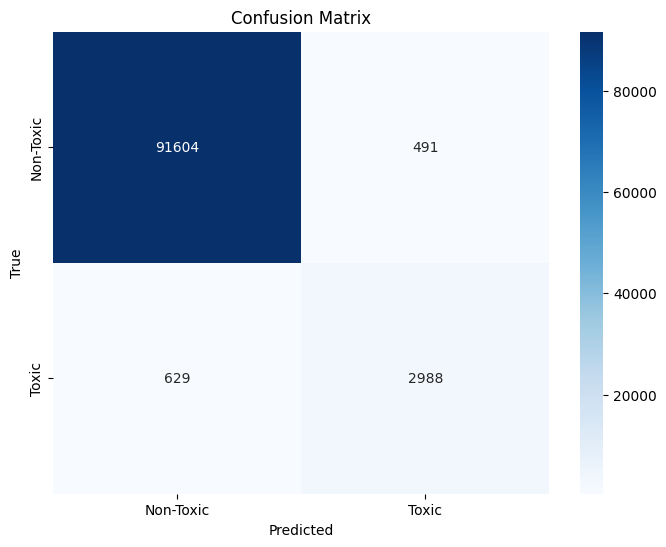

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for the confusion matrix
labels = ['Non-Toxic', 'Toxic']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [19]:
interface = gr.Interface(fn= score_comment, inputs = gr.inputs.Textbox(lines = 2, placeholder= 'comment'), outputs='text')

<ipython-input-19-66c99cfe5ba6>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  interface = gr.Interface(fn= score_comment, inputs = gr.inputs.Textbox(lines = 2, placeholder= 'comment'), outputs='text')
<ipython-input-19-66c99cfe5ba6>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  interface = gr.Interface(fn= score_comment, inputs = gr.inputs.Textbox(lines = 2, placeholder= 'comment'), outputs='text')
<ipython-input-19-66c99cfe5ba6>:1: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  interface = gr.Interface(fn= score_comment, inputs = gr.inputs.Textbox(lines = 2, placeholder= 'comment'), outputs='text')


In [20]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4a5bbafb5c725dc187.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
